In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from numpy.random import choice

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('display.expand_frame_repr', True)

In [197]:
df = pd.read_csv('stud_math.csv', encoding="utf-8")

## Первичный осмотр данных

In [4]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [5]:
df.shape

(395, 30)

В нашем датасете 395 наблюдений с 30 признаками

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,395.0,16.696203,1.276043,15.0,16.0,17.0,18.0,22.0
Medu,392.0,2.750000,1.098127,0.0,2.0,3.0,4.0,4.0
Fedu,371.0,2.614555,2.228732,0.0,2.0,2.0,3.0,40.0
traveltime,367.0,1.438692,0.694181,1.0,1.0,1.0,2.0,4.0
studytime,388.0,2.038660,0.842078,1.0,1.0,2.0,2.0,4.0
failures,373.0,0.337802,0.743135,0.0,0.0,0.0,0.0,3.0
"studytime, granular",388.0,-6.115979,2.526235,-12.0,-6.0,-6.0,-3.0,-3.0
famrel,368.0,3.937500,0.927277,-1.0,4.0,4.0,5.0,5.0
freetime,384.0,3.231771,0.993940,1.0,3.0,3.0,4.0,5.0
goout,387.0,3.105943,1.115896,1.0,2.0,3.0,4.0,5.0


Видим выбросы в колонках *Fedu* (max=40.0) и *Famrel* (min=-1)

Странный признак *studytime, granular*, который, очевидно, повторяет признак *studytime*, умноженный на (-3). Так как признаки идеально скоррелированы, можем позже избавиться от одного из них при построении модели.

В нашей целевой переменной *score* наблюдаем сильное различие между медианой (55) и ст. отклонением (22.9), что противоречит нормальности распределения. Позже изучим дискретные признаки подробнее.

In [7]:
df.dtypes

school                  object
sex                     object
age                      int64
address                 object
famsize                 object
Pstatus                 object
Medu                   float64
Fedu                   float64
Mjob                    object
Fjob                    object
reason                  object
guardian                object
traveltime             float64
studytime              float64
failures               float64
schoolsup               object
famsup                  object
paid                    object
activities              object
nursery                 object
studytime, granular    float64
higher                  object
internet                object
romantic                object
famrel                 float64
freetime               float64
goout                  float64
health                 float64
absences               float64
score                  float64
dtype: object

Проверим, какое количество значений (*cardinality*) принимают наши категориальные переменные

In [8]:
# Занесем все названия категориальных переменных в список
object_cols = [col for col in df.columns if df[col].dtype == "object"]

# У нас также есть кат. переменные с уже закодированными, числовыми значениями. Добавим их в список:
encoded = ["Medu", "Fedu", "traveltime", "studytime", "failures", 
           "famrel", "freetime", "goout", "health"]

for item in encoded:
    object_cols.append(item)

In [9]:
# Сколько уникальных значений принимают наши катег. переменные?
object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Отсортируем кол-во уникальных значений по возрастанию
sorted(d.items(), key=lambda x: x[1])

[('school', 2),
 ('sex', 2),
 ('address', 2),
 ('famsize', 2),
 ('Pstatus', 2),
 ('schoolsup', 2),
 ('famsup', 2),
 ('paid', 2),
 ('activities', 2),
 ('nursery', 2),
 ('higher', 2),
 ('internet', 2),
 ('romantic', 2),
 ('guardian', 3),
 ('reason', 4),
 ('traveltime', 4),
 ('studytime', 4),
 ('failures', 4),
 ('Mjob', 5),
 ('Fjob', 5),
 ('Medu', 5),
 ('freetime', 5),
 ('goout', 5),
 ('health', 5),
 ('Fedu', 6),
 ('famrel', 6)]

Наблюдаем 13 переменных, принимающих лишь два значения. В целом наши категориальные признаки принимают небольшое число значений, с максимумов 5 (если не учитывать выбросы в *Fedu* & *famrel*), значит мы можем закодировать их, создав dummy-переменные для последующего моделирования.

## Оптимизация использования памяти

Так как большинство переменных в датасете являются категориальными (даже на первый взгляд количественные переменные *age*, *absences* и *score* суть тоже категориальные, так как принимают ограниченное количество [числовых] значений), мы можем существенно снизить объем используемой для хранения данных оперативной памяти, применив pandas метод astype("category"). 

In [210]:
df.memory_usage(deep=True)

Index                    128
school                 23305
sex                    22910
age                     3160
address                22468
famsize                22944
Pstatus                21740
Medu                    3160
Fedu                    3160
Mjob                   24472
Fjob                   23821
reason                 24528
guardian               23896
traveltime              3160
studytime               3160
failures                3160
schoolsup              23113
famsup                 22471
paid                   22380
activities             23122
nursery                23173
studytime, granular     3160
higher                 23121
internet               22692
romantic               22592
famrel                  3160
freetime                3160
goout                   3160
health                  3160
absences                3160
score                   3160
dtype: int64

In [213]:
print(f"Всего использовано памяти ДО оптимизации: {df.memory_usage(deep=True).sum()} байт")

Всего использовано памяти ДО оптимизации: 433956 байт


In [214]:
for column in df.columns:
    df[column] = df[column].astype("category")

In [215]:
df.memory_usage(deep=True)

Index                   128
school                  593
sex                     591
age                     779
address                 591
famsize                 595
Pstatus                 591
Medu                    595
Fedu                    603
Mjob                    873
Fjob                    873
reason                  808
guardian                663
traveltime              587
studytime               587
failures                587
schoolsup               594
famsup                  594
paid                    594
activities              594
nursery                 594
studytime, granular     587
higher                  594
internet                594
romantic                594
famrel                  603
freetime                595
goout                   595
health                  595
absences               1963
score                  1179
dtype: int64

In [225]:
print(f"Всего использовано памяти ПОСЛЕ оптимизации: {df.memory_usage(deep=True).sum()} байт")
print("Мы добились 20кратного снижения используемой для хранения датасета ОП")

Всего использовано памяти ПОСЛЕ оптимизации: 20733 байт
Мы добились 20кратного снижения используемой для хранения датасета ОП


## Работа с пропусками

In [218]:
df.isna().sum()

school                  0
sex                     0
age                     0
address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

Во всех признаках, кроме первых трех, наблюдаем пропуски. Изобразим графически:

<AxesSubplot:>

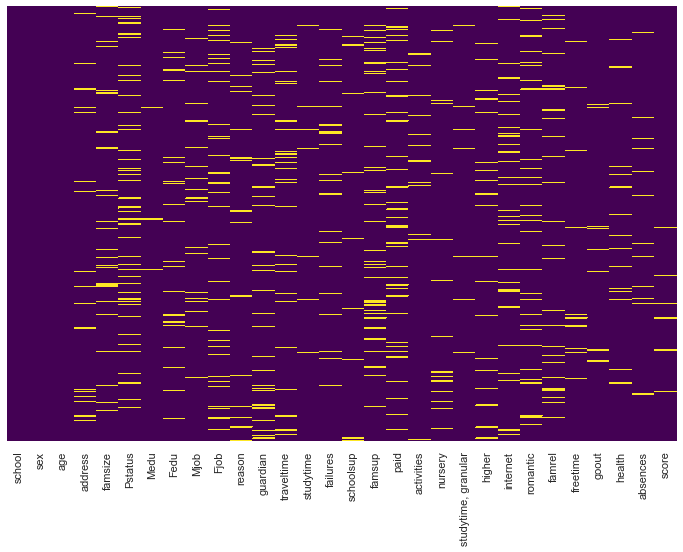

In [219]:
fig, ax = plt.subplots(figsize=(12,8)) 
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

Избавимся от наблюдений с пропусками в нашей целевой переменной (*score*)

In [220]:
df.dropna(axis=0, subset=['score'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [221]:
df.shape

(389, 30)

In [222]:
print(f"Процент пропусков от общего числа данных составляет {round((df.isna().sum().sum() / np.prod(df.shape))*100, 2)} %")

Процент пропусков от общего числа данных составляет 4.71 %


In [223]:
df.isna().sum().sort_values(ascending=False)[:6]

Pstatus     45
paid        39
famsup      38
Fjob        36
internet    34
romantic    31
dtype: int64

Больше всего пропусков наблюдаем в признаках ['Pstatus', 'paid', 'famsup', 'Fjob', 'internet', 'romantic']

In [224]:
print(f"Максимальный процент пропущенных данных от общего числа наблюдений составляет {round(df.isna().sum().sort_values(ascending=False)[:6][0] / df.shape[0]*100, 2)} %")


Максимальный процент пропущенных данных от общего числа наблюдений составляет 11.57 %


Пропущено 11 и менее процентов от общего количества наблюдений. Удаление столбцов с пропусками считаю нецелесообразным, так как в таком случае мы теряем большой объем потенциально полезных для нашей модели данных.

Далее поработаем с пропусками в каждом типе переменных.

## Дихотомические переменные (Binary Features)

В нашем датасете достаточно много дихотомических признаков (переменная принимает лишь два значения). Выделим их в отдельный датафрейм:

In [17]:
bin_var = ["school", "sex", "address", "famsize", "Pstatus", "schoolsup", "famsup", 
           "paid", "activities", "nursery", "higher", "internet", "romantic"]

df_binary = df.loc[:, bin_var]

Визуализируем эти признаки:

[(0.0, 1.0)]

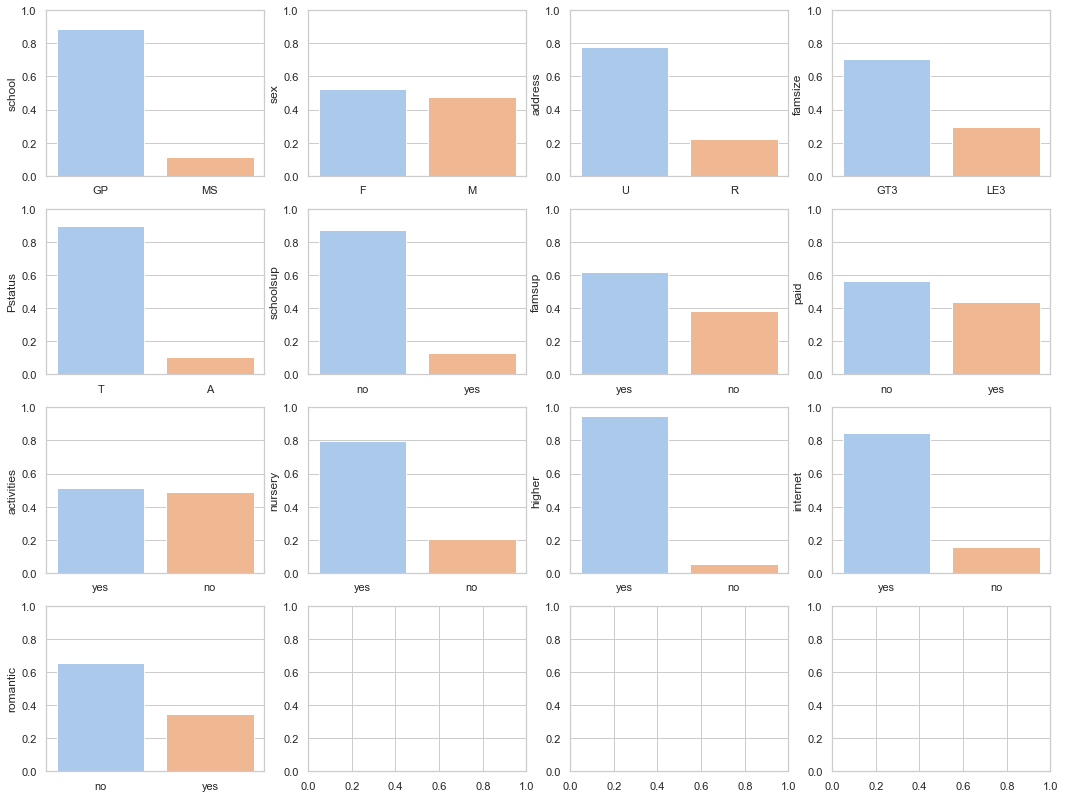

In [196]:
f, ax = plt.subplots(4, 4, figsize=(18,14))

sns.set(style="whitegrid")

f1 = sns.barplot(x = df_binary["school"].value_counts(normalize=True).index, 
                 y = df_binary["school"].value_counts(normalize=True), palette = "pastel", ax=ax[0][0])

f1.set(ylim=(0, 1))

f2 = sns.barplot(x = df_binary["sex"].value_counts(normalize=True).index, 
                 y = df_binary["sex"].value_counts(normalize=True), palette = "pastel", ax=ax[0][1])

f2.set(ylim=(0, 1))

f3 = sns.barplot(x = df_binary["address"].value_counts(normalize=True).index, 
                 y = df_binary["address"].value_counts(normalize=True), palette = "pastel", ax=ax[0][2])

f3.set(ylim=(0, 1))

f4 = sns.barplot(x = df_binary["famsize"].value_counts(normalize=True).index, 
                 y = df_binary["famsize"].value_counts(normalize=True), palette = "pastel", ax=ax[0][3])

f4.set(ylim=(0, 1))

f5 = sns.barplot(x = df_binary["Pstatus"].value_counts(normalize=True).index, 
                 y = df_binary["Pstatus"].value_counts(normalize=True), palette = "pastel", ax=ax[1][0])

f5.set(ylim=(0, 1))

f6 = sns.barplot(x = df_binary["schoolsup"].value_counts(normalize=True).index, 
                 y = df_binary["schoolsup"].value_counts(normalize=True), palette = "pastel", ax=ax[1][1])

f6.set(ylim=(0, 1))

f7 = sns.barplot(x = df_binary["famsup"].value_counts(normalize=True).index, 
                 y = df_binary["famsup"].value_counts(normalize=True), palette = "pastel", ax=ax[1][2])

f7.set(ylim=(0, 1))

f8 = sns.barplot(x = df_binary["paid"].value_counts(normalize=True).index, 
                 y = df_binary["paid"].value_counts(normalize=True), palette = "pastel", ax=ax[1][3])

f8.set(ylim=(0, 1))

f9 = sns.barplot(x = df_binary["activities"].value_counts(normalize=True).index, 
                 y = df_binary["activities"].value_counts(normalize=True), palette = "pastel", ax=ax[2][0])

f9.set(ylim=(0, 1))

f10 = sns.barplot(x = df_binary["nursery"].value_counts(normalize=True).index, 
                  y = df_binary["nursery"].value_counts(normalize=True), palette = "pastel", ax=ax[2][1])

f10.set(ylim=(0, 1))

f11 = sns.barplot(x = df_binary["higher"].value_counts(normalize=True).index, 
                  y = df_binary["higher"].value_counts(normalize=True), palette = "pastel", ax=ax[2][2])

f11.set(ylim=(0, 1))

f12 = sns.barplot(x = df_binary["internet"].value_counts(normalize=True).index, 
                  y = df_binary["internet"].value_counts(normalize=True), palette = "pastel", ax=ax[2][3])

f12.set(ylim=(0, 1))

f13 = sns.barplot(x = df_binary["romantic"].value_counts(normalize=True).index, 
                  y = df_binary["romantic"].value_counts(normalize=True), palette = "pastel", ax=ax[3][0])

f13.set(ylim=(0, 1))


# Безуспешно пытался реализовать это с помощью цикла. Получается только расположив графики вертикально друг под другом:

# for i in df_binary.columns:
#     bin_num = df_binary[i].value_counts(normalize=False)
#     print("graph for %s" % (i))
#     sns.barplot(x = bin_num.index, y = bin_num)
#     plt.show()


Как видно из графиков, большинство признаков имеют одно ярко выраженное значение. Исключения составляют признаки *sex* (однако он не имеет пропусков), *famsup*, *paid* и *activities*

Пропуски в признаках с одним ярко выраженным значением заполним этим значением (*most_frequent*). Для этого воспользуемся методом [SimpleImputer](https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation) из библиотеки **sklearn**

In [19]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [20]:
# df_binary -most frequent-
df_binary_mf = df_binary.loc[:, ["school", "address", "famsize", "Pstatus", "schoolsup", 
                                 "nursery", "higher", "internet", "romantic"]]

imp.fit(df_binary_mf)
df_binary_mf_imp = pd.DataFrame(imp.transform(df_binary_mf))

# Imputation убирает название столбцов, вернем их
df_binary_mf_imp.columns = df_binary_mf.columns

In [21]:
# Проверим, ушли ли пропуски
df_binary_mf_imp.isna().sum()

school       0
address      0
famsize      0
Pstatus      0
schoolsup    0
nursery      0
higher       0
internet     0
romantic     0
dtype: int64

Теперь займемся дихотом. признаками, где значения распределены примерно поровну. Пропуски в них заменим предыдущим значением в столбце:

In [22]:
# df_binary -equal-
df_binary_eq = df_binary.loc[:, ["sex", "famsup", "paid", "activities"]]
df_binary_eq_imp = df_binary_eq.copy(deep=True)

df_binary_eq_imp["famsup"] = df_binary_eq["famsup"].fillna(method="ffill")
df_binary_eq_imp["paid"] = df_binary_eq["paid"].fillna(method="ffill")
df_binary_eq_imp["activities"] = df_binary_eq["activities"].fillna(method="ffill")

In [23]:
df_binary_eq_imp.isna().sum()

sex           0
famsup        0
paid          0
activities    0
dtype: int64

In [226]:
print(df_binary_eq_imp.shape)
print(df_binary_mf_imp.shape)

(389, 4)
(389, 9)


Объединим получившиеся датафреймы

In [26]:
df_binary_imp = pd.concat([df_binary_eq_imp, df_binary_mf_imp], axis=1)

In [27]:
df_binary_imp.isna().sum()

sex           0
famsup        0
paid          0
activities    0
school        0
address       0
famsize       0
Pstatus       0
schoolsup     0
nursery       0
higher        0
internet      0
romantic      0
dtype: int64

In [28]:
df_binary_imp.shape

(389, 13)

Дихотомические признаки теперь не содержат пропусков. Посмотрим, как теперь они выглядят на графиках.

[(0.0, 1.0)]

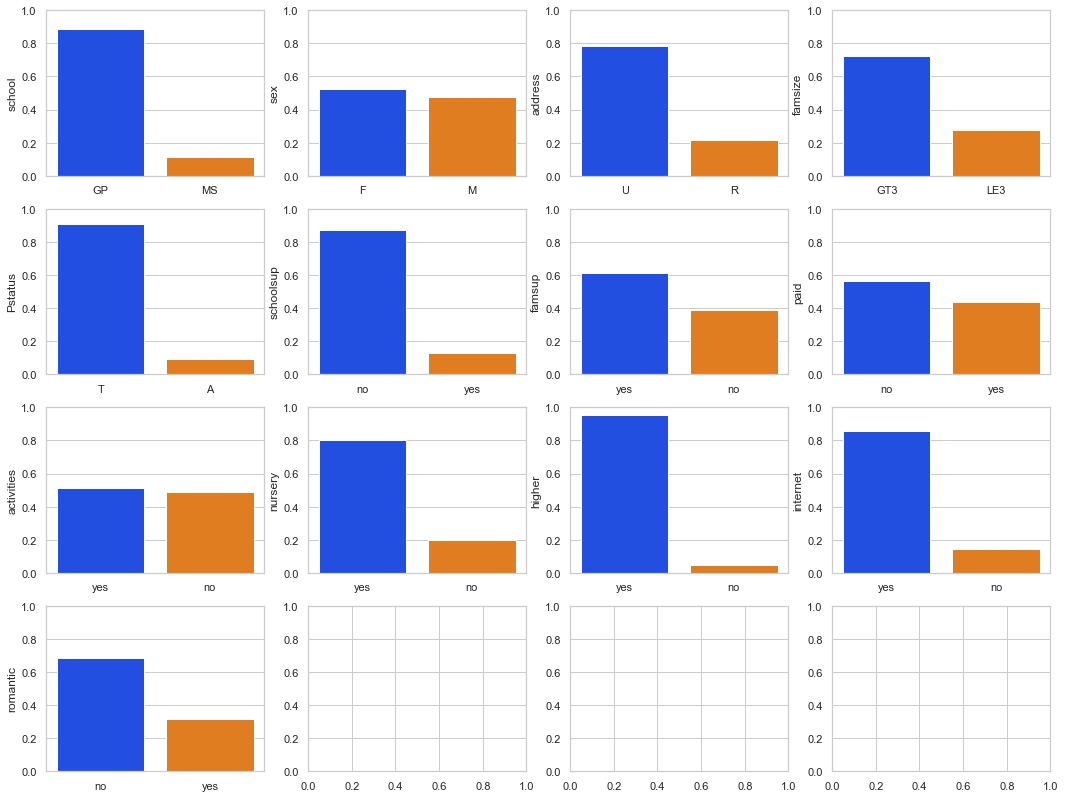

In [29]:
f, ax = plt.subplots(4, 4, figsize=(18,14))

sns.set(style="whitegrid")

f1 = sns.barplot(x = df_binary_imp["school"].value_counts(normalize=True).index, 
                 y = df_binary_imp["school"].value_counts(normalize=True), palette = "bright", ax=ax[0][0])

f1.set(ylim=(0, 1))

f2 = sns.barplot(x = df_binary_imp["sex"].value_counts(normalize=True).index, 
                 y = df_binary_imp["sex"].value_counts(normalize=True), palette = "bright", ax=ax[0][1])

f2.set(ylim=(0, 1))

f3 = sns.barplot(x = df_binary_imp["address"].value_counts(normalize=True).index, 
                 y = df_binary_imp["address"].value_counts(normalize=True), palette = "bright", ax=ax[0][2])

f3.set(ylim=(0, 1))

f4 = sns.barplot(x = df_binary_imp["famsize"].value_counts(normalize=True).index, 
                 y = df_binary_imp["famsize"].value_counts(normalize=True), palette = "bright", ax=ax[0][3])

f4.set(ylim=(0, 1))

f5 = sns.barplot(x = df_binary_imp["Pstatus"].value_counts(normalize=True).index, 
                 y = df_binary_imp["Pstatus"].value_counts(normalize=True), palette = "bright", ax=ax[1][0])

f5.set(ylim=(0, 1))

f6 = sns.barplot(x = df_binary_imp["schoolsup"].value_counts(normalize=True).index, 
                 y = df_binary_imp["schoolsup"].value_counts(normalize=True), palette = "bright", ax=ax[1][1])

f6.set(ylim=(0, 1))

f7 = sns.barplot(x = df_binary_imp["famsup"].value_counts(normalize=True).index, 
                 y = df_binary_imp["famsup"].value_counts(normalize=True), palette = "bright", ax=ax[1][2])

f7.set(ylim=(0, 1))

f8 = sns.barplot(x = df_binary_imp["paid"].value_counts(normalize=True).index, 
                 y = df_binary_imp["paid"].value_counts(normalize=True), palette = "bright", ax=ax[1][3])

f8.set(ylim=(0, 1))

f9 = sns.barplot(x = df_binary_imp["activities"].value_counts(normalize=True).index, 
                 y = df_binary_imp["activities"].value_counts(normalize=True), palette = "bright", ax=ax[2][0])

f9.set(ylim=(0, 1))

f10 = sns.barplot(x = df_binary_imp["nursery"].value_counts(normalize=True).index, 
                  y = df_binary_imp["nursery"].value_counts(normalize=True), palette = "bright", ax=ax[2][1])

f10.set(ylim=(0, 1))

f11 = sns.barplot(x = df_binary_imp["higher"].value_counts(normalize=True).index, 
                  y = df_binary_imp["higher"].value_counts(normalize=True), palette = "bright", ax=ax[2][2])

f11.set(ylim=(0, 1))

f12 = sns.barplot(x = df_binary_imp["internet"].value_counts(normalize=True).index, 
                  y = df_binary_imp["internet"].value_counts(normalize=True), palette = "bright", ax=ax[2][3])

f12.set(ylim=(0, 1))

f13 = sns.barplot(x = df_binary_imp["romantic"].value_counts(normalize=True).index, 
                  y = df_binary_imp["romantic"].value_counts(normalize=True), palette = "bright", ax=ax[3][0])

f13.set(ylim=(0, 1))

## Порядковые переменные (Ordinal Features)

In [30]:
df_ordinal = df.loc[:, ["Medu", "Fedu", "traveltime", "studytime", "failures", 
                        "famrel", "freetime", "goout", "health"]]

Визуализируем значения наших порядковых переменных:

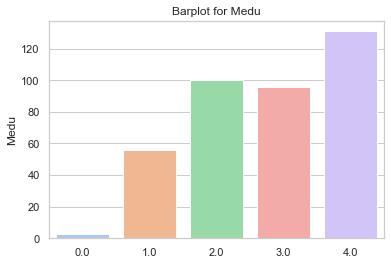

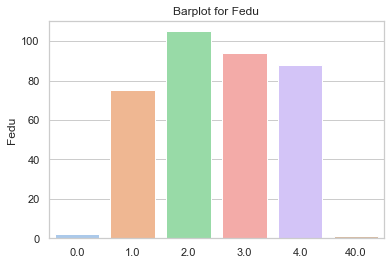

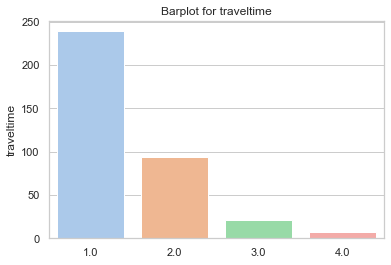

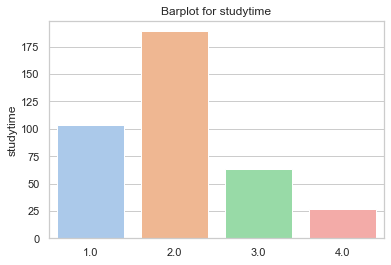

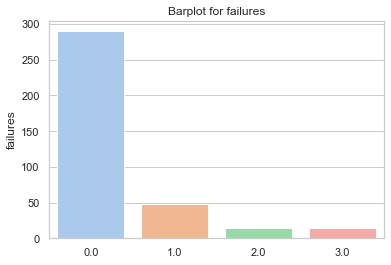

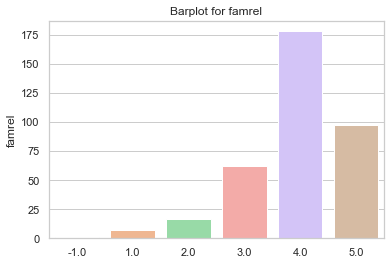

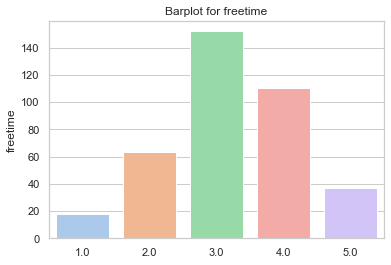

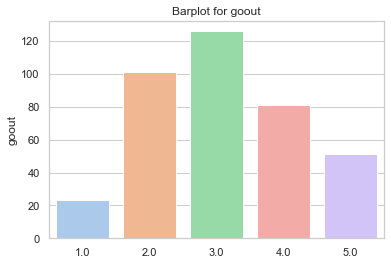

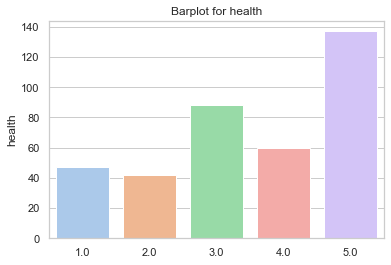

In [31]:
for i in df_ordinal.columns:
    ord_num = df_ordinal[i].value_counts()
    fig, ax = plt.subplots(figsize=(6,4))
    sns.set_style("whitegrid")
    sns.barplot(x = ord_num.index, y = ord_num, ci = None, palette = "pastel", orient = 'v', ax=ax)
    ax.set_title('Barplot for ' + i)
    plt.show()

Займемся выбросами в столбцах *Fedu* и *famrel*

In [32]:
# Предположу, что значение 40 в столбце Fedu это ошибочно записанное значение 4
df_ordinal["Fedu"] = df_ordinal.Fedu.apply(lambda x: 4.0 if x > 4.0 else x)

In [33]:
df_ordinal["Fedu"].value_counts()

2.0    105
3.0     94
4.0     89
1.0     75
0.0      2
Name: Fedu, dtype: int64

In [34]:
# Предположу, что значение -1 в переменной famrel это ошибочно записанное значение 1
df_ordinal["famrel"] = df_ordinal.famrel.apply(lambda x: 1.0 if x < 1.0 else x)

In [35]:
df_ordinal["famrel"].value_counts()

4.0    178
5.0     97
3.0     62
2.0     17
1.0      8
Name: famrel, dtype: int64

Теперь займемся пропусками

In [36]:
df_ordinal.isnull().sum()

Medu           3
Fedu          24
traveltime    28
studytime      7
failures      22
famrel        27
freetime       9
goout          7
health        15
dtype: int64

На этот раз воспользуемся более сложным подходом [IterativeImputer](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation) из **sklearn**, который моделирует каждый признак с пропущенными значениями как функцию других признаков, используя ее для заполнения пропусков.

In [37]:
# multivariate feature imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# в качестве estimator используем DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

In [38]:
imp = IterativeImputer(estimator = DecisionTreeRegressor(), max_iter=10, verbose=0, random_state=0)

In [39]:
imp.fit(df_ordinal)

IterativeImputer(estimator=DecisionTreeRegressor(), random_state=0)

In [40]:
imp.transform(df_ordinal)

array([[4., 4., 2., ..., 3., 4., 3.],
       [1., 1., 1., ..., 3., 3., 3.],
       [1., 1., 1., ..., 3., 2., 3.],
       ...,
       [1., 1., 1., ..., 5., 3., 3.],
       [3., 2., 3., ..., 4., 1., 5.],
       [1., 1., 1., ..., 2., 3., 5.]])

In [41]:
df_ordinal_imp = pd.DataFrame(np.round(imp.transform(df_ordinal)))
df_ordinal_imp.columns = df_ordinal.columns

In [42]:
df_ordinal_imp.isna().sum()

Medu          0
Fedu          0
traveltime    0
studytime     0
failures      0
famrel        0
freetime      0
goout         0
health        0
dtype: int64

Проверим, остались ли пропуски

In [230]:
df_ordinal.famrel.value_counts(dropna=False)

4.0    178
5.0     97
3.0     62
NaN     27
2.0     17
1.0      8
Name: famrel, dtype: int64

In [231]:
df_ordinal_imp.famrel.value_counts(dropna=False)

4.0    194
5.0    102
3.0     65
2.0     18
1.0     10
Name: famrel, dtype: int64

Видим, что 27 пропущенных значений признака *famrel* были распределены среди всех значений признака, руководствуясь логикой модели *DecisionTreeRegressor*.

Еще раз визуализируем очищенные признаки

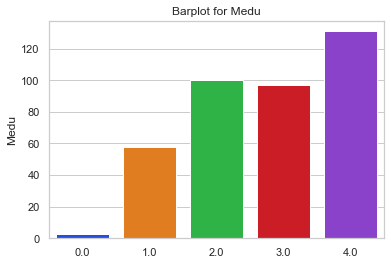

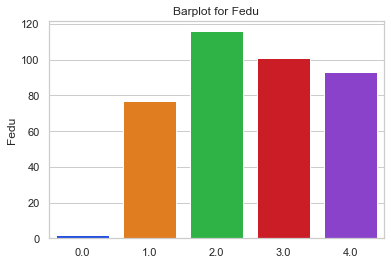

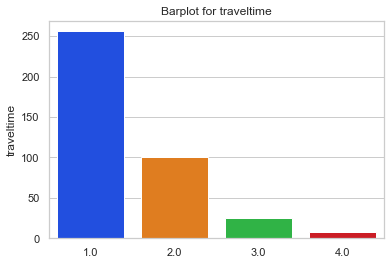

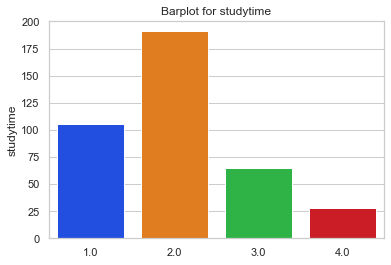

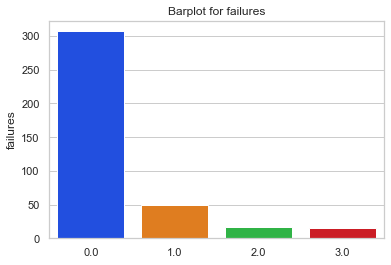

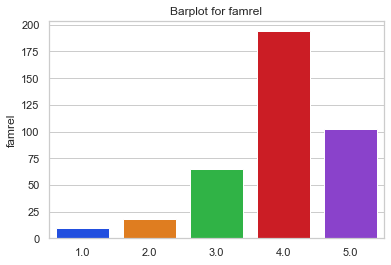

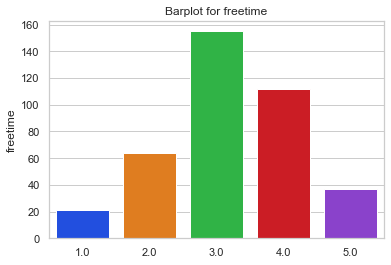

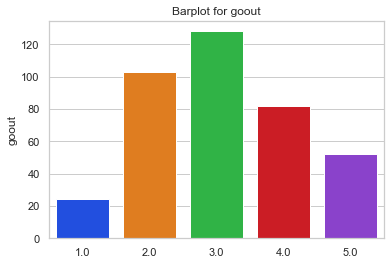

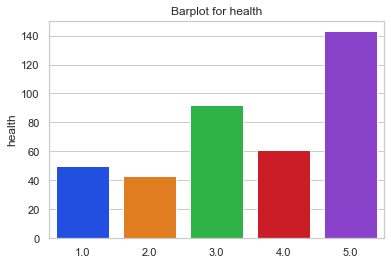

In [45]:
for i in df_ordinal_imp.columns:
    ord_num = df_ordinal_imp[i].value_counts()
    fig, ax= plt.subplots(figsize=(6,4))
    sns.set_style("whitegrid")
    sns.barplot(x = ord_num.index, y = ord_num, ci = None, palette = "bright", orient = 'v', ax=ax)
    ax.set_title('Barplot for ' + i)
    plt.show()

## Номинальные переменные (Nominal Features)

In [46]:
# создадим датафрейм для наших номинальных переменных
df_nominal = df.loc[:, ["Mjob", "Fjob", "reason", "guardian"]]

Визуализируем номинальне переменные

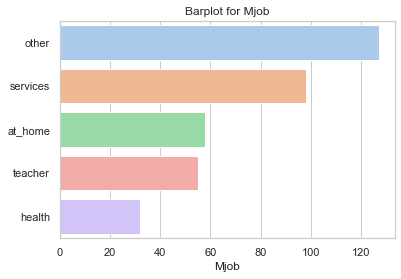

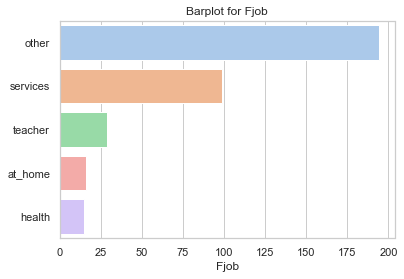

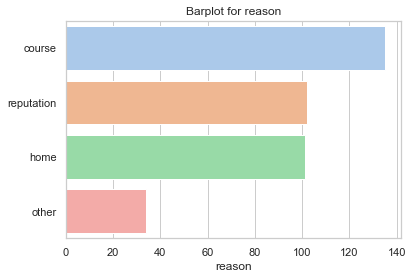

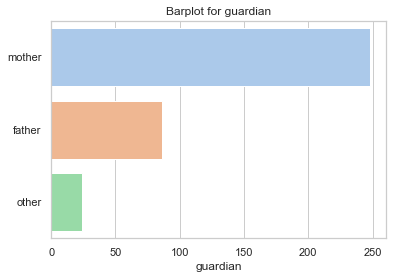

In [47]:
for i in df_nominal.columns:
    nom_num = df_nominal[i].value_counts()
    fig, ax= plt.subplots(figsize=(6,4))
    sns.set_style("whitegrid")
    sns.barplot(x = nom_num, y = nom_num.index, ci = None, palette = "pastel", orient = 'h', ax=ax)
    ax.set_title('Barplot for ' + i)
    plt.show()

Займемся пропусками

In [48]:
df_nominal.isnull().sum()

Mjob        19
Fjob        36
reason      17
guardian    31
dtype: int64

Пропуски заполним значениями переменной, взвешенными по вероятностям их появления в признаке (*value_counts(normalize=True)*)

In [49]:
def mjob_fill(row):
    elements = df_nominal.Mjob.value_counts().index.to_list() # возможные знач-я переменной
    weights = df_nominal.Mjob.value_counts(normalize=True).tolist() # вероятности (веса) появления значения в признаке
    if pd.isnull(row.Mjob):
        return choice(elements, p=weights)
    return row.Mjob

In [50]:
df_nominal_imp = df_nominal.copy(deep=True)

In [51]:
df_nominal_imp["Mjob"] = df_nominal_imp.apply(mjob_fill, axis=1)

In [52]:
df_nominal_imp["Mjob"].isna().sum()

0

In [53]:
def fjob_fill(row):
    elements = df_nominal.Fjob.value_counts().index.to_list() # возможные знач-я переменной
    weights = df_nominal.Fjob.value_counts(normalize=True).tolist() # вероятности (веса) появления значения в признаке
    if pd.isnull(row.Fjob):
        return choice(elements, p=weights)
    return row.Fjob

In [54]:
df_nominal_imp["Fjob"] = df_nominal_imp.apply(fjob_fill, axis=1)

In [55]:
df_nominal_imp["Fjob"].isna().sum()

0

In [56]:
def reason_fill(row):
    elements = df_nominal.reason.value_counts().index.to_list()
    weights = df_nominal.reason.value_counts(normalize=True).tolist()
    if pd.isnull(row.reason):
        return choice(elements, p=weights)
    return row.reason

In [57]:
df_nominal_imp["reason"] = df_nominal_imp.apply(reason_fill, axis=1)

In [58]:
df_nominal_imp["reason"].isna().sum()

0

In [59]:
def guardian_fill(row):
    elements = df_nominal.guardian.value_counts().index.to_list()
    weights = df_nominal.guardian.value_counts(normalize=True).tolist()
    if pd.isnull(row.guardian):
        return choice(elements, p=weights)
    return row.guardian

In [60]:
df_nominal_imp["guardian"] = df_nominal_imp.apply(guardian_fill, axis=1)

In [61]:
df_nominal_imp.isna().sum()

Mjob        0
Fjob        0
reason      0
guardian    0
dtype: int64

Еще раз визуализируем результаты

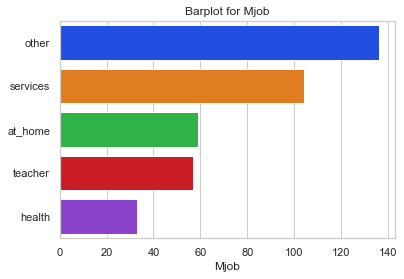

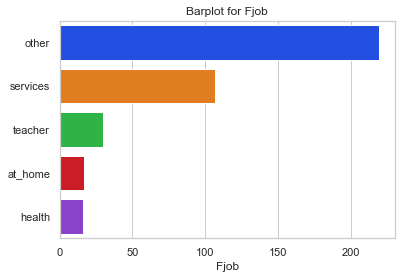

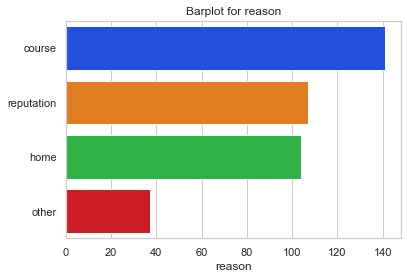

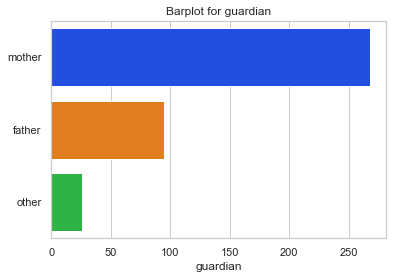

In [62]:
for i in df_nominal_imp.columns:
    nom_num = df_nominal_imp[i].value_counts()
    fig, ax = plt.subplots(figsize=(6,4))
    sns.set_style("whitegrid")
    sns.barplot(x = nom_num, y = nom_num.index, ci = None, palette = "bright", orient = 'h', ax=ax)
    ax.set_title('Barplot for ' + i)
    plt.show()

## Числовые признаки (Numirical Features)

In [63]:
# выделим числовые признаки в отдельный датасет
df_num = df.loc[:, ["age", "absences"]]

Histogram age


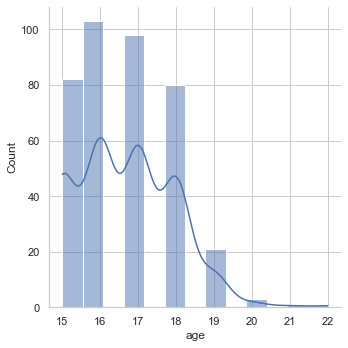

Histogram absences


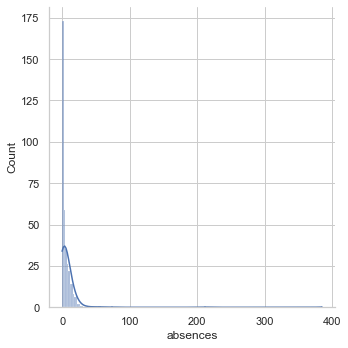

In [64]:
for i in df_num.columns:
    rat_num = df_num[i]
    print("Histogram %s" % (i))
    sns.set_style("whitegrid")
    sns.displot(df_num, x = i, kde=True)
    plt.show()

В признаке *absences* наблюдаем выбросы.

<AxesSubplot:title={'center':"Boxplot for 'absences'"}>

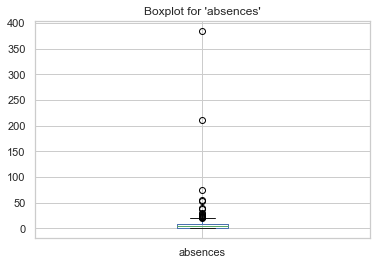

In [65]:
df_num.absences.plot(kind="box", title="Boxplot for 'absences'")

Заменим два крайних выброса на медианные значения:

In [66]:
df_num["absences"] = df_num.absences.apply(lambda x: df_num["absences"].median() if x > 100 else x)

Заменим пропуски на медианные значения:

In [67]:
df_num["absences"] = df_num.absences.fillna(df_num.absences.mean())

In [68]:
df_num.isna().sum()

age         0
absences    0
dtype: int64

<AxesSubplot:>

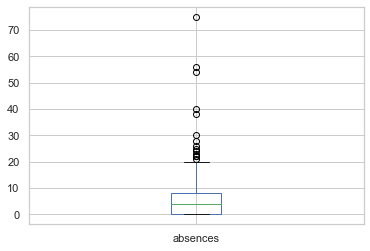

In [69]:
df_num.absences.plot(kind="box")

## Целевая переменная (Response)

Отдельно рассмотрим нашу целевую переменную *score*.

In [70]:
y = df.score

In [71]:
display(y.value_counts())
print()
print(f"Целевая переменная 'score' принимает {y.nunique()} значений")

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64


Целевая переменная 'score' принимает 18 значений


Видим, что целевая переменная является категориальной величиной. Балл ученика по математике присваивается не точным значением, а округляется с шагом 5. Таким образом, переменная может принимать лишь *y.max() / 5.0 = 20* значений. Применять будем модель классификации, а не регрессии.

Изучим распределение значений признака.

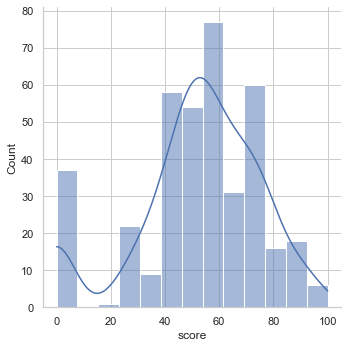

In [72]:
sns.displot(y, kde=True)

Распределение признака *score* можно было бы считать нормальным, если бы не аномально большое количество нулевых значений. Проверим, не лежат ли они за пределами трех стандартных отклонений (т.е. не являются ли они выбросами)

In [73]:
y_mean, y_std = np.mean(y), np.std(y)
cut_off = y_std * 3
lower, upper = y_mean - cut_off, y_mean + cut_off

In [74]:
outliers = [x for x in y if x < lower or x > upper]

In [75]:
print(outliers)

[]


<AxesSubplot:>

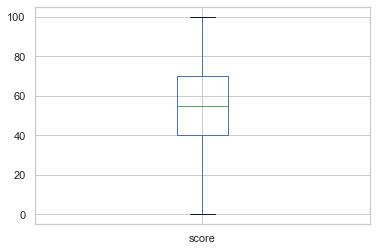

In [76]:
y.plot(kind="box")

Нулевые значения не являются выбросами. 

Теперь, когда все признаки избавлены от пропусков и выбросов, объединим все в один датафрейм.

In [77]:
df_imp = pd.concat([df_binary_imp, df_ordinal_imp, df_nominal_imp, df_num, y], axis=1)

In [78]:
df_imp.shape

(389, 29)

In [79]:
df_imp.isnull().sum()

sex           0
famsup        0
paid          0
activities    0
school        0
address       0
famsize       0
Pstatus       0
schoolsup     0
nursery       0
higher        0
internet      0
romantic      0
Medu          0
Fedu          0
traveltime    0
studytime     0
failures      0
famrel        0
freetime      0
goout         0
health        0
Mjob          0
Fjob          0
reason        0
guardian      0
age           0
absences      0
score         0
dtype: int64

In [235]:
df_imp.memory_usage(deep=True).sum()

438563

*Похоже работа над оптимизацией используемой памяти в начале оказалась напрасной :(*

## Выбор признаков для модели (Feature Selection)

#### 1) Анализ номинативных переменных

Проверим, различаются ли распределения баллов в зависимости от значения наших номинативных переменных. Для этого построим boxplot для каждой переменной.

In [81]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (7, 4))
    sns.boxplot(x=column, y='score', 
                data=df_imp.loc[df_imp.loc[:, column].isin(df_imp.loc[:, column].value_counts().index)], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

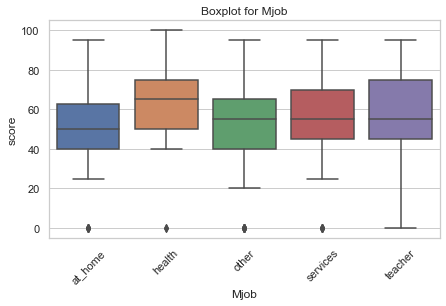

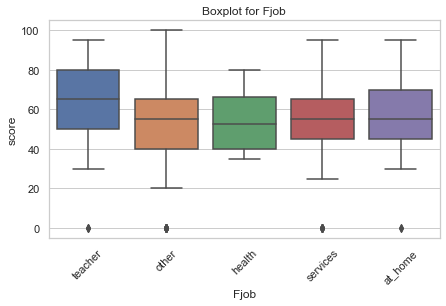

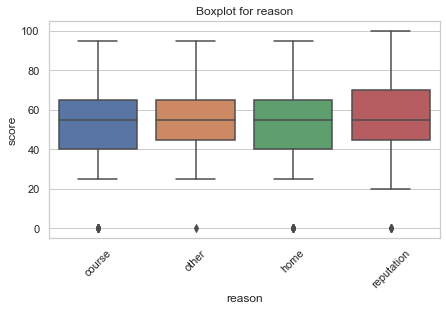

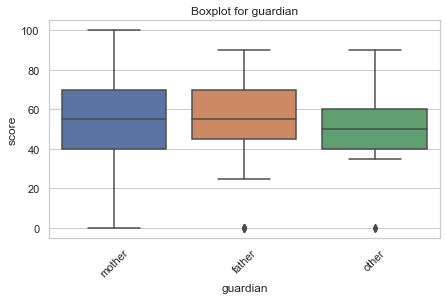

In [82]:
for col in df_nominal_imp.columns:
    get_boxplot(col)

Не похоже, чтобы переменные *reason* и *guardian* оказывали существенное влияние на целевую переменную.

Однако графики являются лишь вспомогательным инструментом, настоящую значимость различий может помочь распознать статистика. Проверим, есть ли статистическая разница в распределении баллов по номинативным признакам, с помощью **теста Стьюдента**. Проверим нулевую гипотезу о том, что распределения баллов учеников по математике по различным параметрам неразличимы:

In [83]:
def get_stat_dif(column):
    cols = df_imp.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df_imp.loc[df_imp.loc[:, column] == comb[0], 'score'], 
                        df_imp.loc[df_imp.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            l.append(column)
            print('Найдены статистически значимые различия для признака', column)
        else:
            print(f"Для признака {column} не найдено статистически значимых различий")
            break

In [84]:
for col in df_nominal_imp.columns.to_list():
    get_stat_dif(col)

Для признака Mjob не найдено статистически значимых различий
Для признака Fjob не найдено статистически значимых различий
Для признака reason не найдено статистически значимых различий
Для признака guardian не найдено статистически значимых различий


Нулевая гипотеза подтвердилась. Ни один из номинальных признаков не оказывает существенного влияния на зависимую переменную *score*.

#### 2) Анализ оставшихся признаков

Чтобы проанализировать влияние оставшихся признаков на целевую переменную, проведем корреляционный анализ.

Но сначала создадим на основе наших дихотом. переменных dummy переменные.

In [86]:
df_imp_dummies = pd.get_dummies(df_imp, columns=df_binary.columns, drop_first=True)

Построим корреляционную матрицу и тепловую карту на ее основе для наглядности:

In [87]:
corr_mat = df_imp_dummies.drop(df_nominal_imp.columns, axis="columns").corr()

<AxesSubplot:>

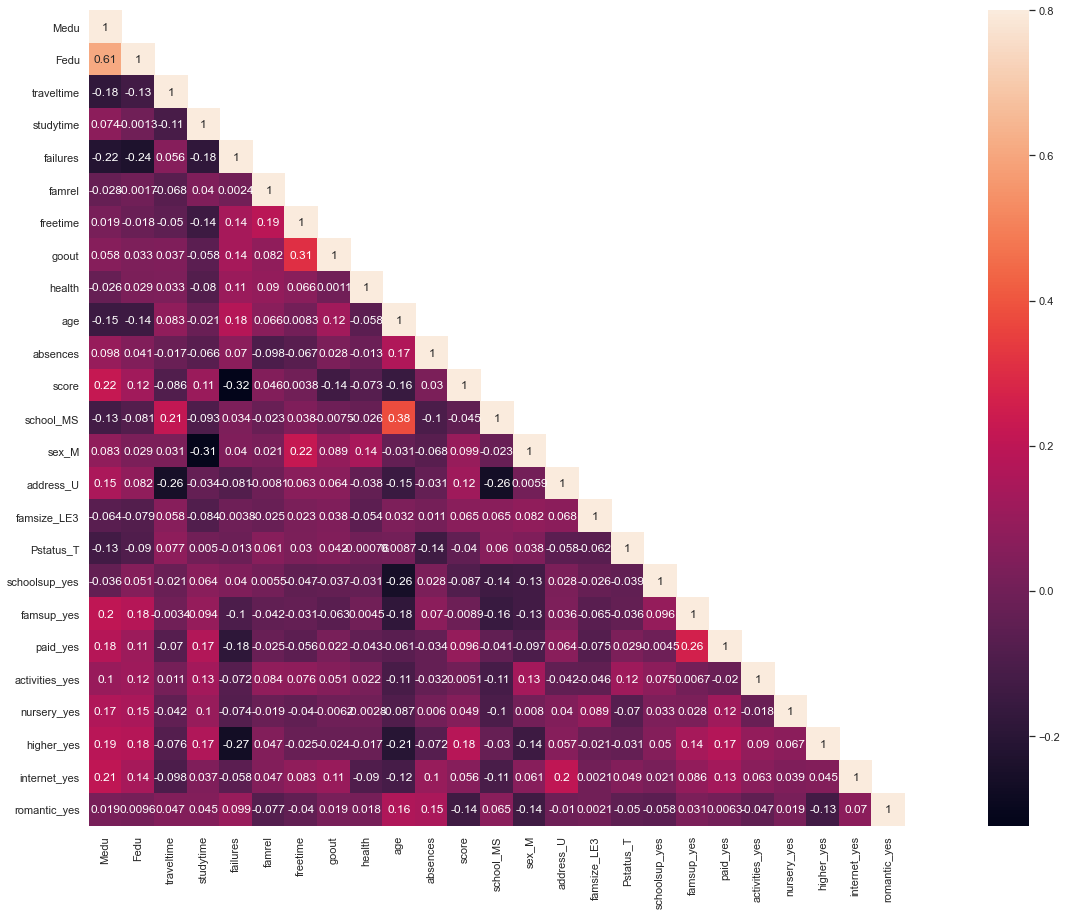

In [88]:
mask = np.array(corr_mat)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(30,15)
sns.heatmap(corr_mat, mask=mask,vmax=.8, square=True,annot=True)

**Некоторые интересные наблюдения:**

* Образование родителей сильно скоррелированы, что позволяет сделать выводы о том, что люди как правило выбирают себе пару со схожим уровнем образования;

* Также хорошее образование родителей оказывает положительный эффект на такие переменные как *internet*, *higher*, *nursery*, *paid*, *famsup* и *score*. Эту взаимосвязь можно было бы предположить логически.

* Живущие за городом ученики (*address*) в среднем тратят больше времени на дорогу до школы (*traveltime*). Видим также, что адрес влияет на выбор школы (*school*).

* Мальчики тратят в среднем меньше времени на учебу помимо школы (*studytime*);

* Количество внеучебных неудач (*failures*) оказывает слабое негативное влияние на желание получить высшеее образование (*higher*) а так же на наличие дополнительных платных занятий по математике (*paid*). Хотя здесь сложно установить причинность;

* Мальчики имеют больше свободного времени после школы (*freetime*) и [как следствие] чаще проводят время с друзьями (*goout*);

* Более старшие ученики как правило учатся в школе типа MS;

* Живущие в городе ученики (*address == U*) чаще имеют доступ к интернету;

* Семейная образовательная поддержка (*famsup*) и наличие платных занятий (*paid*) положительно скоррелированы, что можно было бы логически предположить.

* Девочки из нашего датасета чаще состоят в романтических отношениях чем мальчики.

#### 3) Выбор переменных для модели

Основываясь на проведенном корреляционном анализе, для последующего моделирования предлагаю выбрать переменные, чья корреляция по модулю с целевой переменной превышает 0.1:

In [182]:
corr_mat[abs(corr_mat["score"]) > 0.1].score

Medu            0.223656
Fedu            0.124827
studytime       0.109452
failures       -0.324160
goout          -0.135081
age            -0.155726
score           1.000000
address_U       0.121377
higher_yes      0.183924
romantic_yes   -0.136042
Name: score, dtype: float64

In [183]:
model_features = corr_mat[abs(corr_mat["score"]) > 0.1].score.index.to_list()
model_features = model_features[:6] + model_features[7:] + [model_features[6]]

In [184]:
df_model = df_imp_dummies.loc[:, model_features]

In [185]:
df_model.head()

,Medu,Fedu,studytime,failures,goout,age,address_U,higher_yes,romantic_yes,score
0,4.0,4.0,2.0,0.0,4.0,18,1,1,0,30.0
1,1.0,1.0,2.0,0.0,3.0,17,1,1,0,30.0
2,1.0,1.0,2.0,3.0,2.0,15,1,1,0,50.0
3,4.0,2.0,3.0,0.0,2.0,15,1,1,1,75.0
4,3.0,3.0,2.0,0.0,2.0,16,1,1,0,50.0


Уберем переменную *Fedu*, так как она достаточно сильно скореллирована с переменной *Medu*.

In [186]:
df_model.drop("Fedu", axis=1, inplace=True)

In [187]:
df_model.head()

,Medu,studytime,failures,goout,age,address_U,higher_yes,romantic_yes,score
0,4.0,2.0,0.0,4.0,18,1,1,0,30.0
1,1.0,2.0,0.0,3.0,17,1,1,0,30.0
2,1.0,2.0,3.0,2.0,15,1,1,0,50.0
3,4.0,3.0,0.0,2.0,15,1,1,1,75.0
4,3.0,2.0,0.0,2.0,16,1,1,0,50.0


Итак, в нашем случае важные признаки, которые, возможно, оказывают влияние на целевую переменную, это: *Medu*, *studytime*, *failures*, *goout*, *age*, *address*, *higher* и *romantic*.

In [179]:
X = df_model.drop("score", axis = "columns")
y = df_model.loc[:, "score"].values

## Выводы

В результате EDA для анализа влияния параметров учеников на их итоговый балл по математике были получены следующие выводы:

* Практически во всех признаках были обнаружены пустые значения. В силу относительно малого их количества в каждом отдельно взятом столбце, было принято решение не избавляться от признаков, чтобы не потерять потенциально важные данные для модели. Пропуски были заполнены при использовании различных imputation-методов.

* При первичном осмотре данных выбросы были обнаружены в колонках *Fadu* и *famrel*, а так же позже в количественной переменной *absences*. В целом данные нельзя назвать чистыми. Потребовалось провести достаточно объемную работу, чтобы избавиться от пропусков.

* Смущает большое количество нулевых значений в переменной *score*, анализ которых однако не определил их как выбросы. Эти значения искажают нормальность распределения признака и, скорее всего, негативно повлияют на точность модели.

* Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это *Medu*, *studytime*, *failures*, *goout*, *age*, *address*, *higher* и *romantic*. Однако при построении *tree-based* моделей, я бы рассматривал все имеющиеся признаки.